In [34]:
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt

# Contextual Gene Embeddings (CGE) Tutorial

This tutorial demonstrates how to generate and work with Contextual Gene Embeddings (CGE) using TranscriptFormer. CGE provides gene-specific representations that capture how each gene is contextualized within the full transcriptome of a cell, offering a more granular view compared to traditional mean-pooled cell embeddings.

## Prerequisites

Before starting this tutorial, you need to:

### 1. Install TranscriptFormer
Create a virtual environment with Python 3.11+ and install TranscriptFormer from PyPI using `uv pip install transcriptformer`.

### 2. Download Model Weights and Artifacts
TranscriptFormer requires pre-trained model weights and vocabulary files. Use the CLI command `transcriptformer download tf-sapiens` to download the human-only model, or `transcriptformer download all` for all models and embeddings. Files will be downloaded to `./checkpoints/` by default.

### 3. Prepare Your Data
Your input data should be in H5AD format (AnnData objects) with:
- **Gene IDs**: `var` dataframe must contain an `ensembl_id` column
- **Expression Data**: Unnormalized count data in `adata.X` or `adata.raw.X`
- **Cell Metadata**: Any metadata in `obs` will be preserved

For this tutorial we use a small example set of 1000 human cells. 

## What are Contextual Gene Embeddings?

Traditional cell embeddings are created by mean-pooling gene representations across all genes in a cell. While useful for cell-level analysis, this approach loses gene-specific information and the contextual relationships between genes.

### Key Differences:

| Feature | Cell Embeddings | Contextual Gene Embeddings |
|---------|----------------|---------------------------|
| **Granularity** | One embedding per cell | One embedding per gene per cell |
| **Information** | Mean-pooled across genes | Gene-specific contextual information |
| **Use Cases** | Cell clustering, classification | Gene analysis, regulatory networks |
| **Output Size** | (n_cells, embedding_dim) | (n_gene_instances, embedding_dim) |

## Output Format

The CGE output is stored in a flattened format optimized for HDF5 compatibility with the following components:

1. **`adata.obs`**: Original cell metadata (preserved from input)
2. **`adata.uns['cge_embeddings']`**: 2D array of shape `(n_gene_instances, embedding_dim)`
3. **`adata.uns['cge_cell_indices']`**: Array indicating which cell each embedding belongs to
4. **`adata.uns['cge_gene_names']`**: Array of gene names corresponding to each embedding

## Generate CGEs (with transcriptformer cli)

In [ ]:
%%bash
cd ../
transcriptformer inference --checkpoint-path ./checkpoints/tf_sapiens/ --data-file test/data/human_val.h5ad --emb-type cge --output-filename cge_emb.h5ad


 ___________  ___   _   _  _____           _       _  ______ ______________  ___ ___________
|_   _| ___ \/ _ \ | \ | |/  ___|         (_)     | | |  ___|  _  | ___ \  \/  ||  ___| ___ \
  | | | |_/ / /_\ \|  \| |\ `--.  ___ _ __ _ _ __ | |_| |_  | | | | |_/ / .  . || |__ | |_/ /
  | | |    /|  _  || . ` | `--. \/ __| '__| | '_ \| __|  _| | | | |    /| |\/| ||  __||    /
  | | | |\ \| | | || |\  |/\__/ / (__| |  | | |_) | |_| |   \ \_/ / |\ \| |  | || |___| |\ \
  \_/ \_| \_\_| |_/\_| \_/\____/ \___|_|  |_| .__/ \__\_|    \___/\_| \_\_|  |_/\____/\_| \_|
                                            | |
                                            |_|

[2025-05-28 16:01:23,113][root][INFO] - Loading vocabulary file: ../checkpoints/tf_sapiens/vocabs/assay
[2025-05-28 16:01:23,114][root][INFO] - Loading ESM2 mappings from ../checkpoints/tf_sapiens/vocabs
[2025-05-28 16:01:24,729][root][INFO] - Building gene vocabulary
[2025-05-28 16:01:24,956][root][INFO] - Instantiating Transcriptformer m

/mnt/czi-sci-ai/generate-cross-species-secondary/jpearce/transcriptformer/.venv/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


[2025-05-28 16:01:26,876][root][INFO] - Using 'X' layer from AnnData object
[2025-05-28 16:01:28,091][pytorch_lightning.utilities.rank_zero][INFO] - Using 16bit Automatic Mixed Precision (AMP)
[2025-05-28 16:01:28,092][pytorch_lightning.utilities.rank_zero][INFO] - Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
[2025-05-28 16:01:28,170][pytorch_lightning.utilities.rank_zero][INFO] - GPU available: True (cuda), used: True
[2025-05-28 16:01:28,171][pytorch_lightning.utilities.rank_zero][INFO] - TPU available: False, using: 0 TPU cores
[2025-05-28 16:01:28,172][pytorch_lightning.utilities.rank_zero][INFO] - HPU available: False, using: 0 HPUs
[2025-05-28 16:01:29,301][pytorch_lightning.accelerators.cuda][INFO] - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Predicting DataLoader 0: 100%|██████████| 125/125 [01:37<00:00,  1.29it/s]
[2025-05-28 16:03:07,661][root][INFO] - Combining p

/mnt/czi-sci-ai/generate-cross-species-secondary/jpearce/transcriptformer/.venv/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
... storing 'sangerID' as categorical
... storing 'donor_type' as categorical
... storing 'region' as categorical
... storing 'age' as categorical
... storing 'facility' as categorical
... storing 'flushed' as categorical
... storing 'cell_state' as categorical
... storing 'assay_ontology_term_id' as categorical
... storing 'cell_type_ontology_term_id' as categorical
... storing 'development_stage_ontology_term_id' as categorical
... storing 'donor_id' as categorical
... storing 'disease_ontology_term_id' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'self_reported_ethnicity_ontology_term_id' as categorical
... storing 'sex_ontology_term_id' as categorical
... storing 'suspension_typ

[2025-05-28 16:03:23,062][root][INFO] - Saved embeddings to ./inference_results/cge_emb.h5ad


## Load CGE embeddings

In [37]:
file_path = '../inference_results/cge_emb.h5ad'
adata = ad.read_h5ad(file_path)

print("Gene names shape:", adata.uns['cge_gene_names'].shape)
print("Cell indices shape:", adata.uns['cge_cell_indices'].shape)
print("Embeddings shape:", adata.uns['cge_embeddings'].shape)

Gene names shape: (1976710,)
Cell indices shape: (1976710,)
Embeddings shape: (1976710, 2048)


## Gene distribution

Total number of gene instances: 1976710
Number of unique genes: 16514

Top 10 most frequent genes:
ENSG00000075420    947
ENSG00000096060    942
ENSG00000152601    935
ENSG00000109906    929
ENSG00000156639    912
ENSG00000144642    900
ENSG00000145012    897
ENSG00000140262    894
ENSG00000075151    885
ENSG00000171988    872
Name: count, dtype: int64


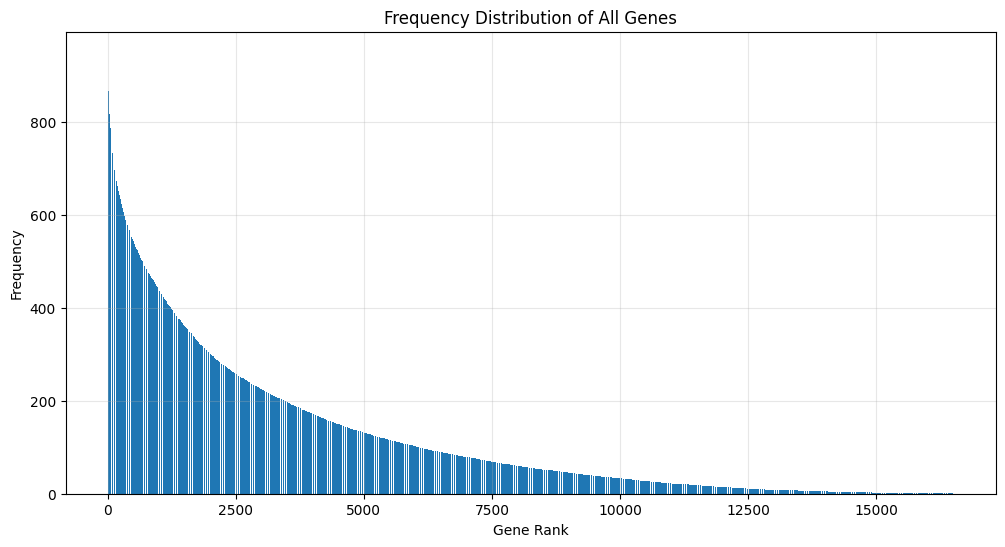

In [16]:
# Get count of each gene name
gene_names = adata.uns['cge_gene_names']
gene_counts = pd.Series(gene_names).value_counts()

print(f"Total number of gene instances: {len(gene_names)}")
print(f"Number of unique genes: {len(gene_counts)}")
print(f"\nTop 10 most frequent genes:")
print(gene_counts.head(10))

# Create histogram of all genes
plt.figure(figsize=(12, 6))
plt.bar(range(len(gene_counts)), gene_counts.values)
plt.xlabel('Gene Rank')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of All Genes')
plt.grid(True, alpha=0.3)
plt.show()


## UMAP of cell type clusters vs gene ID

Random 10 genes: ['ENSG00000233608', 'ENSG00000135457', 'ENSG00000154678', 'ENSG00000143575', 'ENSG00000215717', 'ENSG00000159228', 'ENSG00000163564', 'ENSG00000251192', 'ENSG00000187049', 'ENSG00000100485']
Number of embeddings for random 10 genes: 1650


/mnt/czi-sci-ai/generate-cross-species-secondary/jpearce/transcriptformer/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


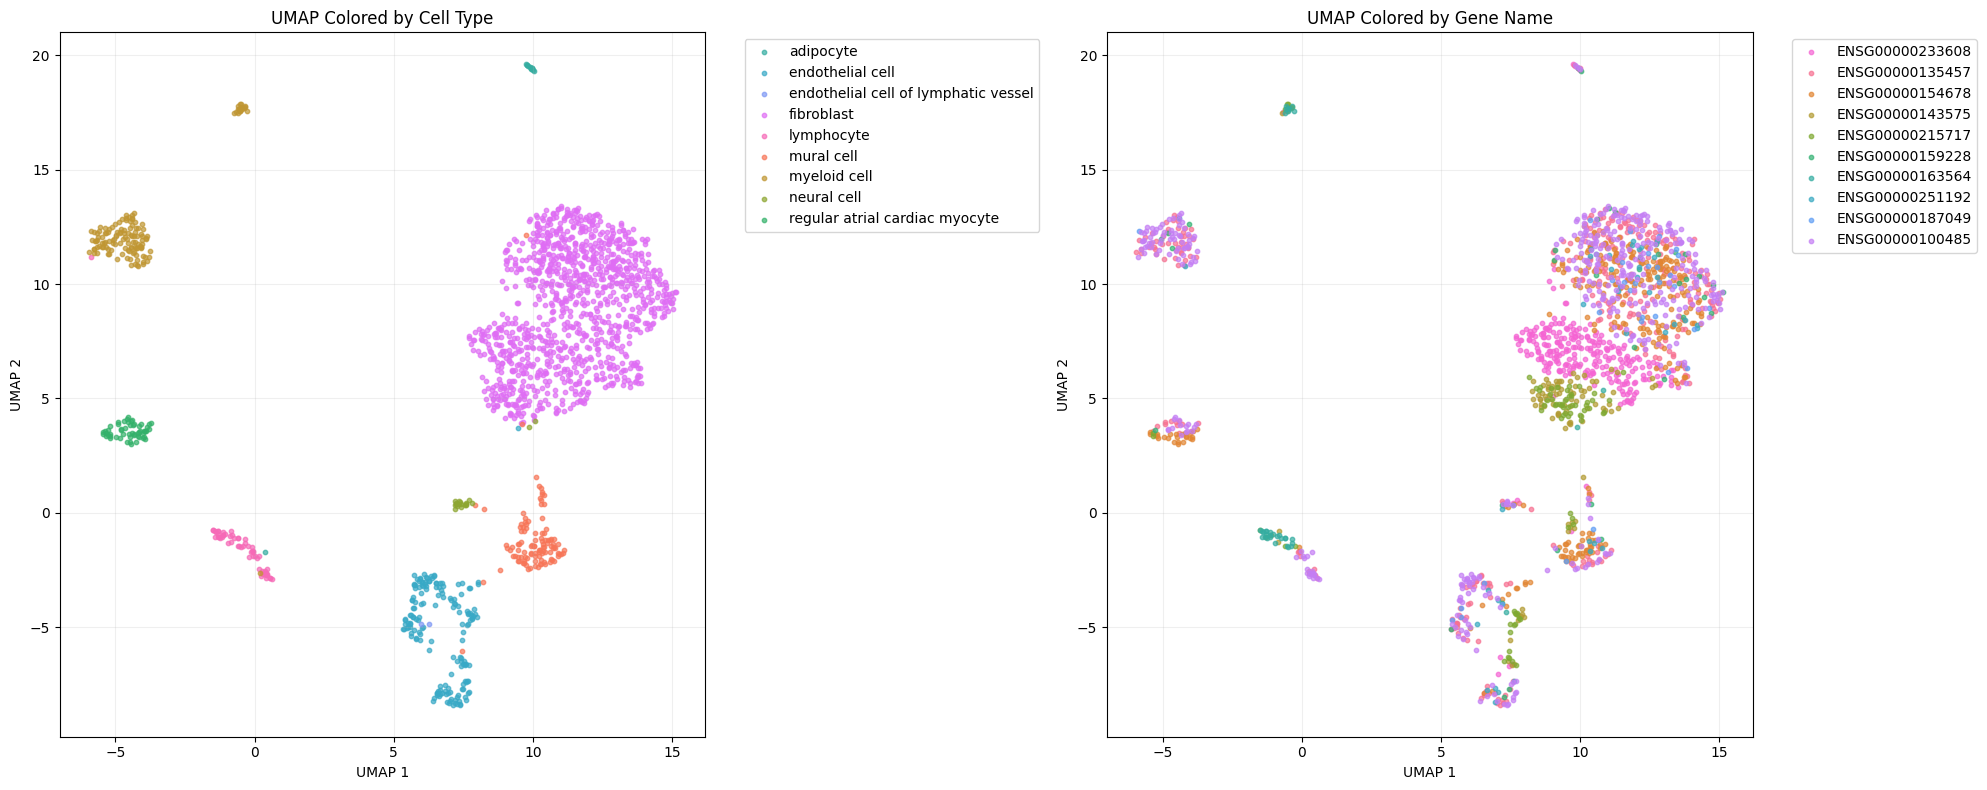

AnnData object with n_obs × n_vars = 1000 × 0
    obs: 'sangerID', 'donor_type', 'region', 'age', 'facility', 'flushed', 'cell_state', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'disease_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'tissue_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    uns: 'cge_cell_indices', 'cge_embeddings', 'cge_gene_names'


In [40]:
import umap
import seaborn as sns

# Get 10 random genes
np.random.seed(42)  # For reproducibility
random_genes = np.random.choice(gene_counts.index, size=10, replace=False).tolist()
print(f"Random 10 genes: {random_genes}")

# Filter embeddings for random 10 genes
random_mask = np.isin(adata.uns['cge_gene_names'], random_genes)
random_embeddings = adata.uns['cge_embeddings'][random_mask]
random_cell_indices = adata.uns['cge_cell_indices'][random_mask]
random_gene_names = adata.uns['cge_gene_names'][random_mask]

print(f"Number of embeddings for random 10 genes: {len(random_embeddings)}")

# Get cell types for the corresponding cells
cell_types = adata.obs['cell_type'].iloc[random_cell_indices].values

# Create UMAP embedding
reducer = umap.UMAP(n_neighbors=15, min_dist=0.5, random_state=42)
umap_embedding = reducer.fit_transform(random_embeddings)

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Colored by cell type
unique_cell_types = np.unique(cell_types)
# Use seaborn's husl color palette for better color discrimination
colors = sns.husl_palette(n_colors=len(unique_cell_types), h=.5)
cell_type_to_color = {ct: colors[i] for i, ct in enumerate(unique_cell_types)}

for cell_type in unique_cell_types:
    ct_mask = cell_types == cell_type
    if np.any(ct_mask):
        ax1.scatter(
            umap_embedding[ct_mask, 0], 
            umap_embedding[ct_mask, 1],
            c=[cell_type_to_color[cell_type]], 
            s=10,
            alpha=0.7,  # Increased alpha for better visibility
            label=cell_type
        )

ax1.set_xlabel('UMAP 1')
ax1.set_ylabel('UMAP 2')
ax1.set_title('UMAP Colored by Cell Type')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.2)  # Reduced grid alpha

# Plot 2: Colored by gene name
# Use a different husl palette for genes with different hue
gene_colors = sns.husl_palette(n_colors=len(random_genes), h=.9)
gene_to_color = {gene: gene_colors[i] for i, gene in enumerate(random_genes)}

for gene in random_genes:
    gene_mask = random_gene_names == gene
    if np.any(gene_mask):
        ax2.scatter(
            umap_embedding[gene_mask, 0], 
            umap_embedding[gene_mask, 1],
            c=[gene_to_color[gene]], 
            s=10,
            alpha=0.7,  # Increased alpha for better visibility
            label=gene
        )

ax2.set_xlabel('UMAP 1')
ax2.set_ylabel('UMAP 2')
ax2.set_title('UMAP Colored by Gene Name')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.2)  # Reduced grid alpha

plt.tight_layout()
plt.show()

print(adata)
